# Interactive sampler

1. train a sampler
2. user can navigate through the sampling process

initialise notebook and logger:

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=1)


## train sampler

In [ ]:
%%time
'''
FIRST WE TRAIN A GRAPHSAMPLER
'''
import graphlearn.utils.draw as myutils
import graphlearn.graphlearn as gl
from eden.converter.graph.gspan import gspan_to_eden
import itertools
import graphlearn.utils.interactive as interactive

# get training graphs
training_graphs = gspan_to_eden( '../toolsdata/bursi.pos.gspan' )
training_size=1000
training_graphs = itertools.islice(training_graphs,training_size)

#create a sampler and fit on training
sampler=gl.Sampler(radius_list=[0,1], thickness_list=[2],random_state=42447,
                          min_cip_count=2, min_interface_count=2,preprocessor=interactive.simple_pp())
sampler.fit(training_graphs)

#prepare interactive module
interactive.setparameters(sampler)

print 'OK'

/Library/Python/2.7/site-packages/sklearn/calibration.py:414: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Library/Python/2.7/site-packages/sklearn/calibration.py:424: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Library/Python/2.7/site-packages/sklearn/calibration.py:426: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


OK
CPU times: user 28.2 s, sys: 3.45 s, total: 31.6 s
Wall time: 37.6 s


## help the sampler in deciding which generated graph to accept

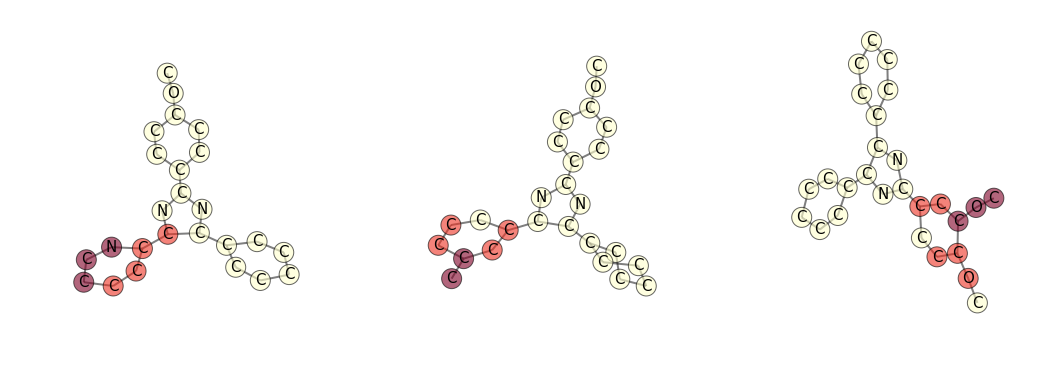

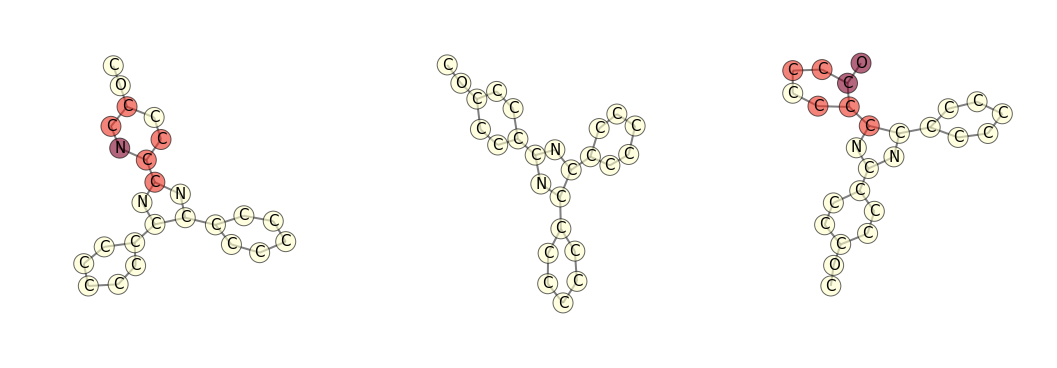

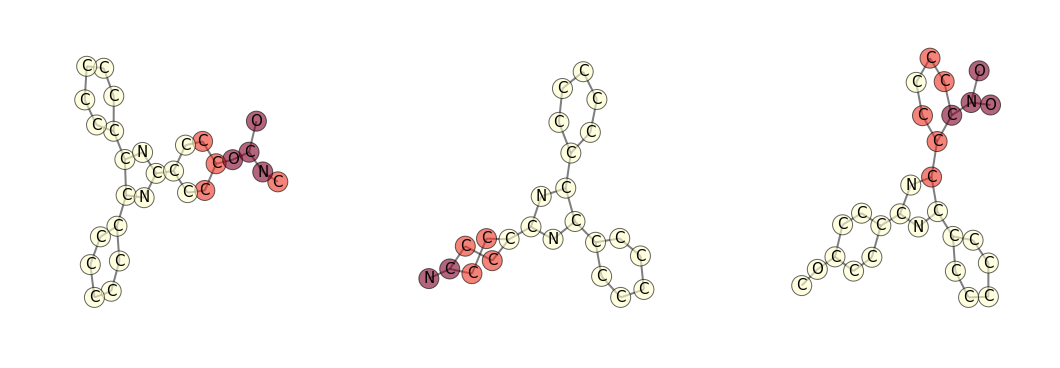

3


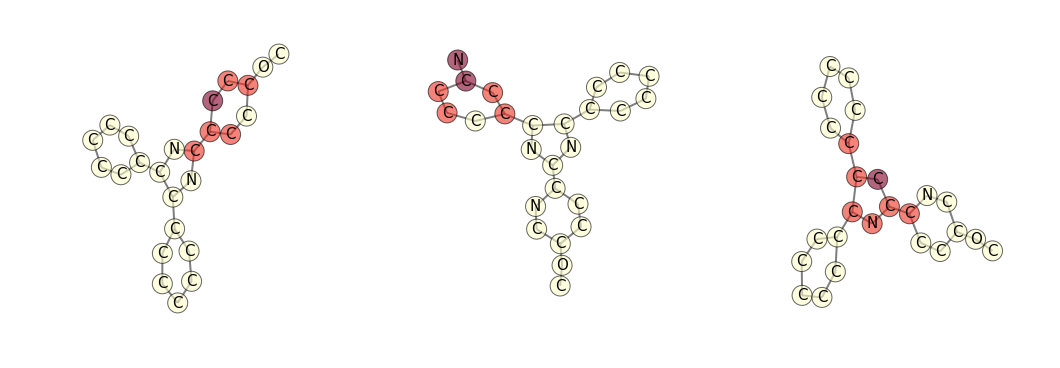

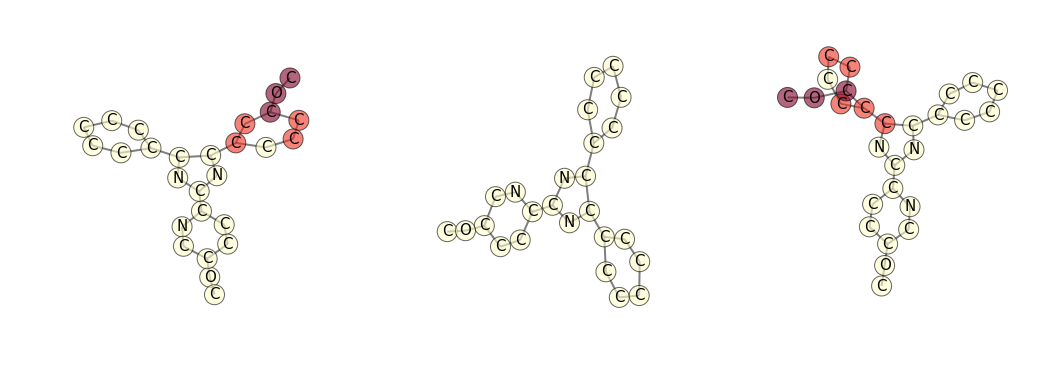

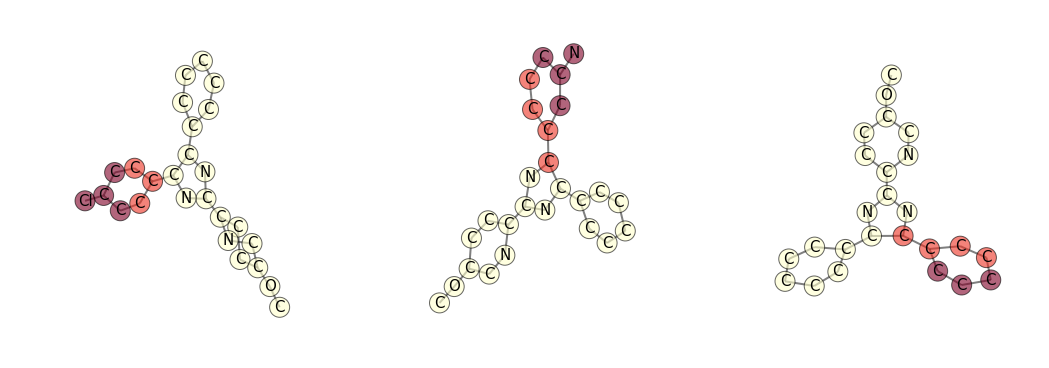

In [ ]:
import networkx as nx
from graphlearn.utils import draw


# choose a start graph
gr = gspan_to_eden( '../toolsdata/bursi.pos.gspan' )
CURRENT = sampler._sample_init(gr.next())

while True:
    # generate 8 graphs
    graphmanz=interactive.easy_get_new_graphs(CURRENT,sampler)
    # put old one in middle (of the plot)
    g=[grman.base_graph() for grman in graphmanz ]
    g=g[:4]+[CURRENT.base_graph()]+g[4:]
    # draw them 
    draw.graphlearn(g,n_graphs_per_line=3, node_size=400,contract=True,node_border=0.5)
    #pick a graph that is the new CURRENT
    x=raw_input()
    CURRENT=graphmanz[int(x)]
    CURRENT.real_clean()

## EXPERT MODE

help the sampler in finding good graph instances

but this time you get to choose a node in the graph you want to work with
as well as the CIP that will be transplanted!


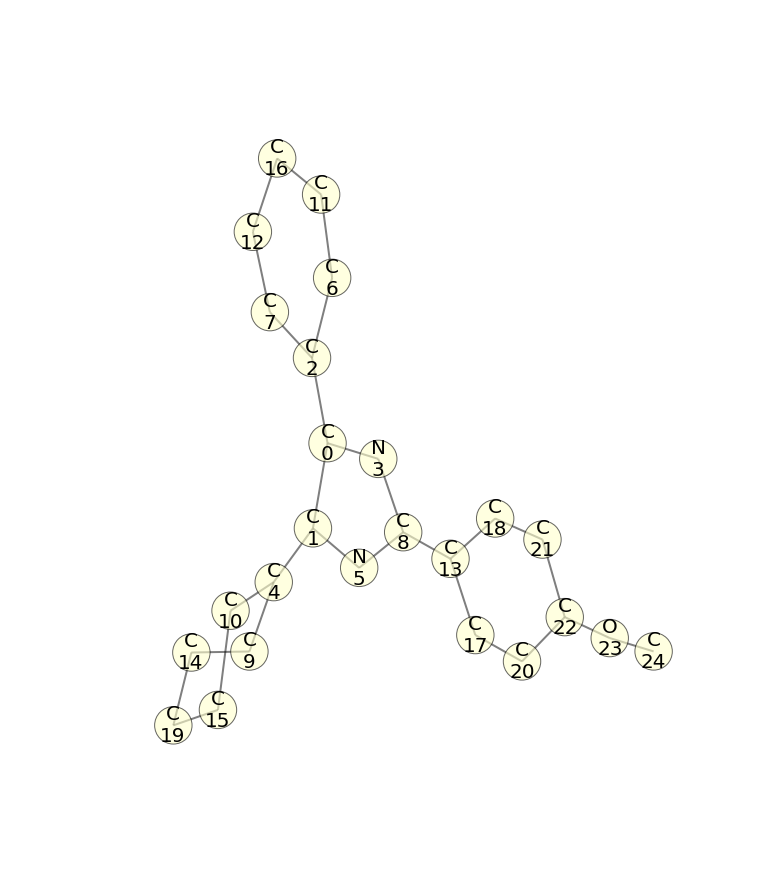

choose a node
22
no replacements found,try again


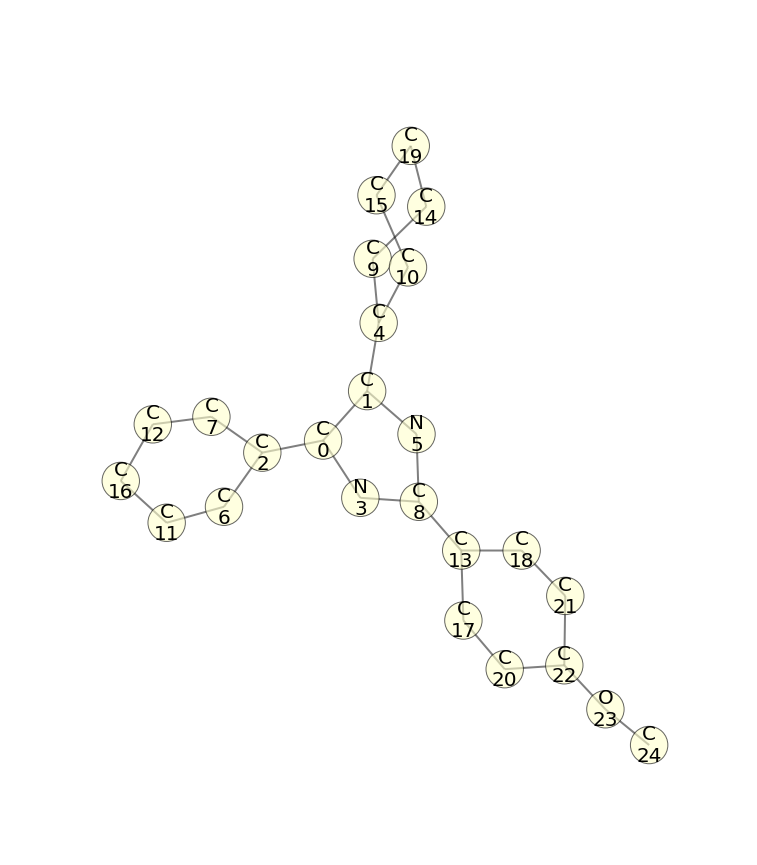

choose a node
0
no replacements found,try again


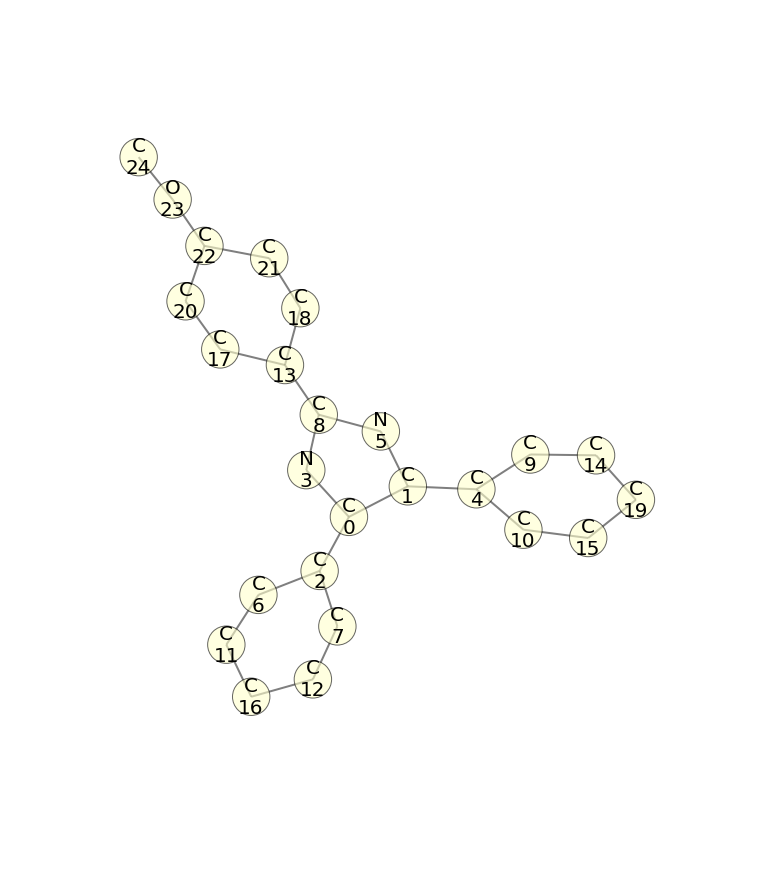

choose a node


KeyboardInterrupt: 

In [4]:

import networkx as nx
from graphlearn.utils import draw


# initialize and provide a graph to work on
args=interactive.getargz(sampler)
gr = gspan_to_eden( '../toolsdata/bursi.pos.gspan' )
CURRENT = sampler._sample_init(gr.next())


while True: 
    # draw graph and choose node
    draw.graphlearn(CURRENT.base_graph(),secondary_vertex_label='id',size=15,contract=True, node_size=1400,font_size=20,node_border=0.5)
    print "choose a node"
    node_id=int(raw_input())
    
    # draw new cips and choose one
    cips=interactive.get_cips(CURRENT,sampler,node_id,args)
    if len(cips)==0:
        print 'no replacements found,try again'
        continue
    cip_graphs=[ c.graph for c in cips ]
    draw.graphlearn(cip_graphs, node_border=0.5, node_size=400,font_size=17,contract=True,title_key='info')
    print "choose a CIP; red nodes will be added"
    cip_id=int(raw_input())
    
    #replace and clean
    gr=CURRENT.core_substitution( cips[cip_id].orig, cip_graphs[cip_id])
    CURRENT=sampler.preprocessor.re_transform_single(gr)
    CURRENT.real_clean()
    

---